In [1]:
import cv2
import keras
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,roc_auc_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
%matplotlib inline

### Data Preparation And Exploration

***Planet supplied ~40,000 satellite images of the rain forest and hand labeled them with tags related to cloudiness, types of natural areas, and types of human impact. We'll be training a CNN model to classify an image as either having evidence of human impact in it, or not. Human impact is defined here as signs of agriculture, habitation, roads, cultivation, slash and burn methods, conventional mines,artisinal mines, or selective logging.***

In [3]:
file_loc = '../planet/planet/'
image_loc = '../planet/planet/train-jpg/'

Load our labels dataframe, which we then make more usable by adding dummy variables for the tags.

In [4]:
tag_df = pd.read_csv(file_loc+'train_classes.csv')

In [5]:
tag_df.head(4)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary


In [6]:
unique_tags = []
for tag in tag_df.tags:
    cur_tags = tag.split(' ')
    for cur_tag in cur_tags:
        if cur_tag not in unique_tags:
            unique_tags.append(cur_tag)

In [7]:
dummied_tags_df = tag_df.copy()
for tag in unique_tags:
    dummied_tags_df[tag] =  dummied_tags_df['tags'].apply(lambda x: 1 if tag in x.split(' ') else 0)

In [8]:
dummied_tags_df.head(4)

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Looking at the proportion of the time a tag shows up in  an image, we can see that some tags are very rare, and most are of primary rain forest.

In [9]:
tag_count = {}
for tag in unique_tags:
    tag_count[tag] = sum(dummied_tags_df[tag])

In [10]:
tag_percent = np.array(list(tag_count.values()))/dummied_tags_df.shape[0]

In [11]:
sorted_tags_perc = sorted(list(zip(list(tag_count.keys()),tag_percent)),key = lambda x : x[1])
sorted_tags = [x[0] for x in sorted_tags_perc]
sorted_perc = [x[1] for x in sorted_tags_perc]

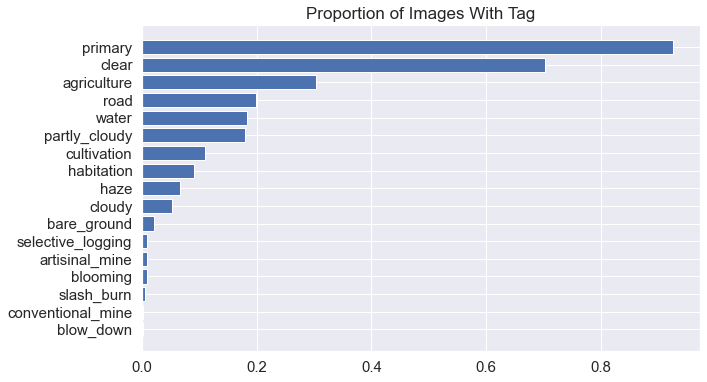

In [12]:
sns.set(rc={'figure.figsize':(10,6)})
plt.barh(sorted_tags,sorted_perc)
plt.title('Proportion of Images With Tag',fontsize = 17)
plt.xticks(fontsize=15)
plt.yticks(fontsize= 15)
plt.show()

Exploring what tags are correlated with eachother we see weather patterns that exclude each other have a very negative correlation, which is expected, and that various types of human impact are correlated with each other, which also makes sense.

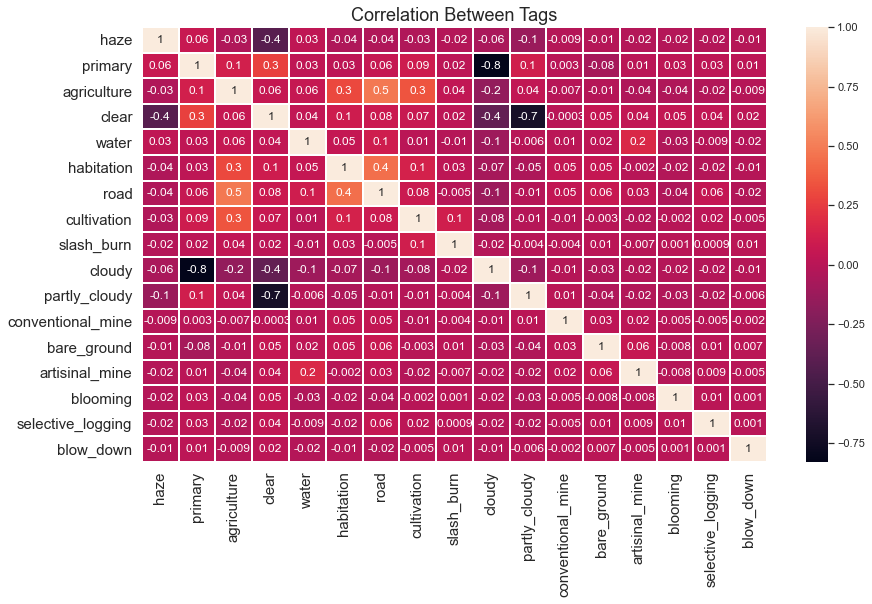

In [13]:
sns.set(rc={'figure.figsize':(14,8)})
sns.heatmap(dummied_tags_df[unique_tags].corr(),annot = True, fmt='.1g',linewidths=1)
plt.title("Correlation Between Tags", fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

Let's get an idea of what each of these tags look like in the images. The cell can be run multiple times for new examples.

<Figure size 1008x1008 with 0 Axes>

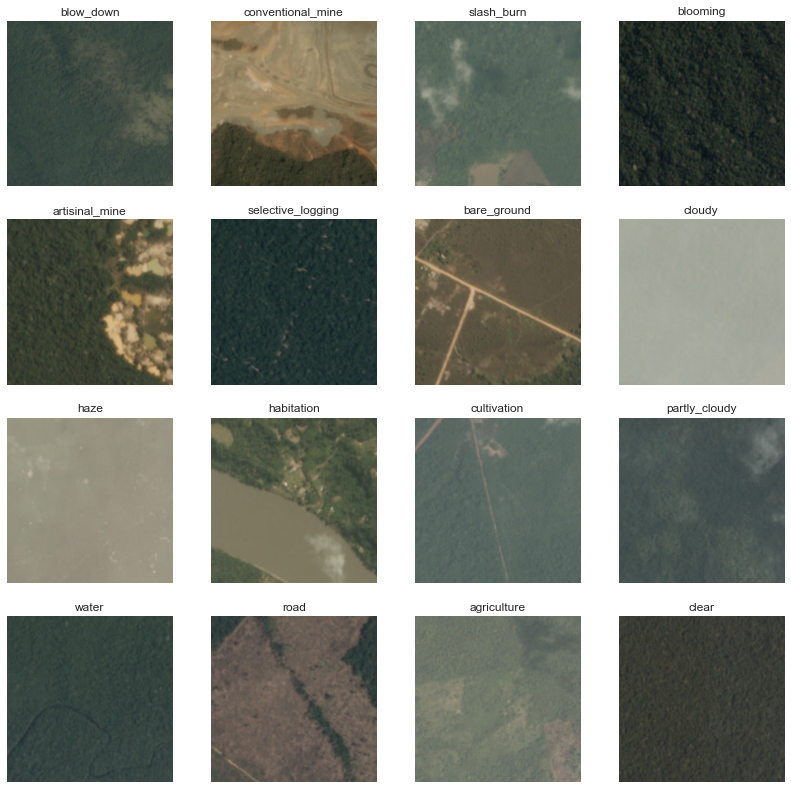

In [14]:
representative_imgs = []
for tag in sorted_tags:
    img = dummied_tags_df[dummied_tags_df[tag] == 1].sample().iloc[0].image_name
    representative_imgs.append(img)

representative_imgs = representative_imgs[:-1]

sns.set(rc={'figure.figsize':(14,14)})
plt.figure()
f, axarr = plt.subplots(4,4)
for i,val in enumerate(representative_imgs):
    col = i%4
    row = 0 if i < 4 else 1 if i < 8 else 2 if i < 12 else 3
    axarr[row,col].imshow(mpimg.imread(image_loc+val+".jpg"))
    axarr[row,col].set_title(sorted_tags[:-1][i])
    axarr[row,col].axis('off')

We now create a label for if there is a noted human impact in an image.

In [15]:
impacted = ['agriculture', 'habitation', 'road', 'cultivation', 'slash_burn', 'conventional_mine','artisinal_mine', 'selective_logging']

In [16]:
dummied_tags_df['human_impact'] = dummied_tags_df['tags'].apply(lambda x: 1 if any(item in impacted for item in x.split(" ")) else 0)

In order to make the run time quicker we'll be decreasing the image size. To make our model more accurate you can keep the images the same size if you have the computing power.

We also split the data into our training, validation, and test data.

In [17]:
np.random.seed(10)
train_ind, val_test_ind = train_test_split(np.arange(dummied_tags_df.shape[0]),test_size=0.3)
val_ind, test_ind = train_test_split(val_test_ind,test_size=0.5)
train_ind = sorted(train_ind)
val_ind = sorted(val_ind)
test_ind = sorted(test_ind)

In [18]:
train_imgs = []
val_imgs = []
test_imgs =[]

for idx, image_name in enumerate(dummied_tags_df.image_name):
    img  = mpimg.imread(image_loc+image_name+'.jpg')
    img = cv2.resize(img, (32,32))
    img =  img/255
    if idx in train_ind:
        train_imgs.append(img)
    elif idx in val_ind:
        val_imgs.append(img)
    else:
        test_imgs.append(img)

train_imgs = np.array(train_imgs)
val_imgs = np.array(val_imgs)
test_imgs = np.array(test_imgs)

### Fitting and Testing the Model

In [19]:
train_labels = dummied_tags_df.human_impact.iloc[train_ind].values
val_labels = dummied_tags_df.human_impact.iloc[val_ind].values
test_labels = dummied_tags_df.human_impact.iloc[test_ind].values

In [20]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [21]:
cnn_mdl = model.fit(train_imgs, train_labels,validation_data=(val_imgs, val_labels),epochs=20, batch_size=200,verbose=1)

Train on 28335 samples, validate on 6072 samples
Epoch 1/20
28335/28335 [==============================] - 30s 1ms/step - loss: 0.5637 - accuracy: 0.7103 - val_loss: 0.5607 - val_accuracy: 0.7286
Epoch 2/20
28335/28335 [==============================] - 28s 991us/step - loss: 0.5151 - accuracy: 0.7575 - val_loss: 0.4878 - val_accuracy: 0.7689
Epoch 3/20
28335/28335 [==============================] - 28s 988us/step - loss: 0.4832 - accuracy: 0.7780 - val_loss: 0.4532 - val_accuracy: 0.7930
Epoch 4/20
28335/28335 [==============================] - 28s 989us/step - loss: 0.4507 - accuracy: 0.7962 - val_loss: 0.4470 - val_accuracy: 0.7974
Epoch 5/20
28335/28335 [==============================] - 28s 984us/step - loss: 0.4222 - accuracy: 0.8119 - val_loss: 0.4126 - val_accuracy: 0.8202
Epoch 6/20
28335/28335 [==============================] - 28s 985us/step - loss: 0.3937 - accuracy: 0.8309 - val_loss: 0.3800 - val_accuracy: 0.8409
Epoch 7/20
28335/28335 [==============================] - 2

We make our predictions to optimize the accuracy by setting the threshold at 0.5. This threshold can be adjusted if we want to increase the sensitivity of the model, as currently the model is more likely to make the error of labeling an image as unimpacted by humans when it has been impacted than the other way around.

In [22]:
pred = model.predict(test_imgs, batch_size=200)
pred = pd.Series(pred.flatten()).apply(lambda x: 1 if x > 0.5 else 0).values

In [23]:
confusion_matrix(test_labels,pred)

array([[3281,  440],
       [ 342, 2009]], dtype=int64)

In [24]:
accuracy_score(test_labels,pred)

0.8712121212121212

In [25]:
roc_auc_score(test_labels, pred)

0.8681411021927007